<!-- vscode-jupyter-toc -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->
<a id='toc0_'></a>**Содержание**    
- [numba](#toc1_)    
- [torch](#toc2_)    
- [pynvml](#toc3_)    
- [Тензоры](#toc4_)    
- [Полезно](#toc5_)    
- [Освобождение памяти (gpu)](#toc6_)    
- [Все объекты данных торча](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- /vscode-jupyter-toc -->

In [1]:
import warnings
warnings.filterwarnings('ignore')

# <a id='toc1_'></a>[numba](#toc0_)

JIT компиляция ОК

0.8219033249999939


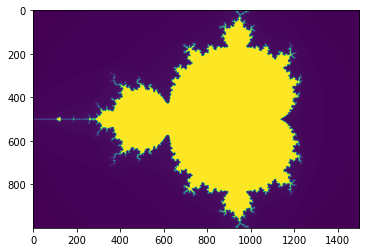

In [2]:
from timeit import default_timer as timer
try:
    from matplotlib.pylab import imshow, show
    have_mpl = True
except ImportError:
    have_mpl = False
import numpy as np
from numba import jit

@jit(nopython=True)
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z * z + c
        if (z.real * z.real + z.imag * z.imag) >= 4:
            return i

    return 255

@jit(nopython=True)
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

image = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)
s = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
e = timer()
print(e - s)
if have_mpl:
    imshow(image)
    show()

на девайсе тоже считает

In [11]:
# https://numba.pydata.org/numba-doc/0.36.1/cuda/random.html

from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
import numpy as np

@cuda.jit
def compute_pi(rng_states, iterations, out):
    """Find the maximum value in values and store in result[0]"""
    thread_id = cuda.grid(1)

    # Compute pi by drawing random (x, y) points and finding what
    # fraction lie inside a unit circle
    inside = 0
    for i in range(iterations):
        x = xoroshiro128p_uniform_float32(rng_states, thread_id)
        y = xoroshiro128p_uniform_float32(rng_states, thread_id)
        if x**2 + y**2 <= 1.0:
            inside += 1

    out[thread_id] = 4.0 * inside / iterations

threads_per_block = 1024
blocks = 1152
rng_states = create_xoroshiro128p_states(threads_per_block * blocks, seed=1)
out = np.zeros(threads_per_block * blocks, dtype=np.float32)

compute_pi[blocks, threads_per_block](rng_states, 10000, out)
print('pi:', out.mean())


pi: 3.141582


# <a id='toc2_'></a>[torch](#toc0_)

тоже вроде работает

In [4]:
import torch
print(torch.rand(5, 3))
print(torch.rand(5).cuda())
torch.cuda.is_available()

tensor([[0.8219, 0.0593, 0.4920],
        [0.2193, 0.4985, 0.3204],
        [0.0473, 0.6680, 0.4965],
        [0.3050, 0.7836, 0.5682],
        [0.0623, 0.4085, 0.0762]])
tensor([0.3501, 0.0853, 0.5737, 0.1561, 0.9265], device='cuda:0')


True

In [5]:
print(torch.__config__.show())

PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.5.2 (Git Hash a9302535553c73243c632ad3c4c80beec3d19a1e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 10.2
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70
  - CuDNN 7.6.5
  - Magma 2.5.2
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=10.2, CUDNN_VERSION=7.6.5, CXX_COMPILER=/opt/rh/devtoolset-7/root/usr/bin/c++, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -fopenmp -DNDEBUG -DUSE_KINETO -DUSE_FBGEMM -DUSE_QNNPACK -DUSE_PYTORCH_QNNPACK -DUSE_XNNPACK -DSYMBOLICATE_MOBILE_DEBUG_HANDLE -DEDGE_PROFILER_USE_KINETO -O2 -fPI

In [6]:
print("Free:\t{}\nTotal:\t{}".format(*torch.cuda.mem_get_info()))

Free:	4744806400
Total:	6214451200


In [7]:
torch.cuda.memory_stats()

OrderedDict([('active.all.allocated', 22),
             ('active.all.current', 0),
             ('active.all.freed', 22),
             ('active.all.peak', 7),
             ('active.large_pool.allocated', 0),
             ('active.large_pool.current', 0),
             ('active.large_pool.freed', 0),
             ('active.large_pool.peak', 0),
             ('active.small_pool.allocated', 22),
             ('active.small_pool.current', 0),
             ('active.small_pool.freed', 22),
             ('active.small_pool.peak', 7),
             ('active_bytes.all.allocated', 11776),
             ('active_bytes.all.current', 0),
             ('active_bytes.all.freed', 11776),
             ('active_bytes.all.peak', 3584),
             ('active_bytes.large_pool.allocated', 0),
             ('active_bytes.large_pool.current', 0),
             ('active_bytes.large_pool.freed', 0),
             ('active_bytes.large_pool.peak', 0),
             ('active_bytes.small_pool.allocated', 11776),
         

In [8]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |    3584 B  |   11776 B  |   11776 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |    3584 B  |   11776 B  |   11776 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |    3584 B  |   11776 B  |   11776 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [9]:
print(torch.cuda.get_device_properties(device='cuda:0'))

_CudaDeviceProperties(name='NVIDIA GeForce RTX 2060', major=7, minor=5, total_memory=5926MB, multi_processor_count=30)


# <a id='toc3_'></a>[pynvml](#toc0_)

- интерфейс для мониторинга и управления видюхой
- ограниченно функционирует
- на нее завязан некоторый мониторинг в пайторче, поэтому там тоже некоторые функции мониторинга не работают

In [12]:
from pynvml.smi import nvidia_smi
nvsmi = nvidia_smi.getInstance()
nvsmi.DeviceQuery('memory.free, memory.total')

{'gpu': [{'fb_memory_usage': {'total': 5926.5625,
    'free': 4510.9375,
    'unit': 'MiB'}}]}

Принудительно освободить GPU из торча не очень то и получится. Этим занимается драйвер самостоятельно, и видимо не всегда хорошо. **Выяснили ниже, все хорошо**.

Можно частично очистить мусор только принудительно.

In [13]:
import gc

gc.collect() # Python thing

with torch.no_grad():
    torch.cuda.empty_cache() # PyTorch thing

Как видно, так ниче не освобождается, подробности ниже

In [14]:
nvsmi.DeviceQuery('memory.free, memory.total')

{'gpu': [{'fb_memory_usage': {'total': 5926.5625,
    'free': 4496.6875,
    'unit': 'MiB'}}]}

# <a id='toc4_'></a>[Тензоры](#toc0_)

- в торче есть маленькие тензоры, но модели торча (по крайней мере, те, которые я уже успел посмотреть) на GPU могут работать только на `float32` (torch.cuda.FloatTensor), а модуль `Embeddings` на вход принимает только `int64` (torch.cuda.LongTensor). Т.е. речь тут тока о типах, которые по 4 байта.

  - в доках написано, что `Embeddings` также должен принимать `int32` (torch.cuda.IntTensor), но у меня это дает `RuntimeError**: expected scalar type Long but found Int`. Может это в последней версии 1.11 под CUDA 11 ??

In [15]:
device = torch.device("cuda")

a = torch.tensor([1, 2, 3], dtype=torch.int8).cuda()
b = torch.CharTensor([-1, 0, 126, 127, 128, 129, 254, 255, 256])

In [16]:
c = torch.tensor([1, 2, 3], dtype=torch.uint8).cuda()
d = torch.ByteTensor([-1, 0, 126, 127, 128, 129, 254, 255, 256])

# <a id='toc5_'></a>[Полезно](#toc0_)

Параметры модели

In [18]:
from prettytable import PrettyTable

def count_parameters(model, verbose=True):
    """Вывод таблицы с параметрами модели в памяти"""
    table = PrettyTable(["Modules/Tensors", "GPU", "Shape", "Parameters", "Type", "DataMem"])
    total_params, total_mem = 0, 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        shape =  " x ".join(map(str,  parameter.size()))
        cuda = "+" if parameter.is_cuda else " "
        t = parameter.dtype
        mem = params * 4 # float32 native
        table.add_row([name, cuda, shape, params, t, mem])
        total_params += params
        total_mem += mem
    if verbose: print(table)
    print(f"Total Trainable Params: {total_params}\nTotal memory (min): {total_mem/1024:,.2f} KB")
    return total_params


model = torch.nn.LSTM(10, 20, 2) # emb_size, rnn_num_units, num_layers

count_parameters(model), sum([p.numel() for p in model.parameters()])

+-----------------+-----+---------+------------+---------------+---------+
| Modules/Tensors | GPU |  Shape  | Parameters |      Type     | DataMem |
+-----------------+-----+---------+------------+---------------+---------+
|   weight_ih_l0  |     | 80 x 10 |    800     | torch.float32 |   3200  |
|   weight_hh_l0  |     | 80 x 20 |    1600    | torch.float32 |   6400  |
|    bias_ih_l0   |     |    80   |     80     | torch.float32 |   320   |
|    bias_hh_l0   |     |    80   |     80     | torch.float32 |   320   |
|   weight_ih_l1  |     | 80 x 20 |    1600    | torch.float32 |   6400  |
|   weight_hh_l1  |     | 80 x 20 |    1600    | torch.float32 |   6400  |
|    bias_ih_l1   |     |    80   |     80     | torch.float32 |   320   |
|    bias_hh_l1   |     |    80   |     80     | torch.float32 |   320   |
+-----------------+-----+---------+------------+---------------+---------+
Total Trainable Params: 5920
Total memory (min): 23.12 KB


(5920, 5920)

# <a id='toc6_'></a>[Освобождение памяти (gpu)](#toc0_)

Тонкостью `jupyter` + `CUDA` является накапливание в GPU моделей с их данными, которые очень быстро выедают память, если их принудительно не выгружать:
- даже если переменная (в которой лежит модель с данными) переопределена, CUDA об этом знать не может, и если модель на GPU, ее память останется аллоцированной
- CUDA деаллоцирует память только после того, как переменную уберет GC
- в юпитере на уровне ноутбука GC не работает, т.к. это одна сессия, и все переменные уровня ячейки - глобальные, никогда не уходят из его области видимости сами, пока открыт ноутбук

Поэтому, чтобы освободить память GPU после модели, когда дальше по расчетам она не нужна, требуется:
- удалить переменную
- собрать мусор
- запустить `torch.cuda.empty_cache()`

Плохая новость, что сделать это компактно, в виде функции не получится (простым способом), для подобных задач даже есть отдельный пакет [python-varname](https://github.com/pwwang/python-varname), который умеет аккуратно работать с питоно-фреймами и правильно вытаскивать имена переменных (и то не всегда, потому что много кто лезет шерудить в этих именах, например `pytest` или операторы `assert`), и это слишком большие сложности чтоб с этим заморачиваться.

Поэтому, когда закончили с моделью и переходим к следующей нужно добавлять 3 строки:

    del <кортеж ненужных тензоров/моделей>
    gc.collect()
    torch.cuda.empty_cache()

100% верно для CUDA 10.2

**UPD**

- нет ничего невозможного, причем все относительно просто

In [19]:
import gc 
import inspect


def _retrieve_name(var):
    """Ищет имя переменной в объемлющей области по значению аргумента
    - поднимается на 2 фрейма по стеку (из точки вызова, если сунуть глубже в цикл, 
      то надо еще дальше вылезать, короче подниматься до целевого неймспейса)
    - находит все имена переменных с таким же значением"""
    callers_local_vars = inspect.currentframe().f_back.f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

def free_mem(*vars):
    for v in vars:
        names = _retrieve_name(v)
        if len(names) == 1:
            del globals()[names[0]]
        else:
            print(f"Skip removing ambiguous vars {names} with the same value.")
    gc.collect()
    torch.cuda.empty_cache()


var1, var2 = [42, 3.14],  42
free_mem(var1, var2)

# <a id='toc7_'></a>[Все объекты данных торча](#toc0_)
- это как отдельные тензоры, так и параметры моделей типа тензор

In [20]:
def dump_tensors():
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    table = PrettyTable(["Kind", "GPU", "Dims", "Parameters", "Type", "Memory", "Var"])
    count, total_params, total_gpu_mem, total_cpu_mem = 0, 0, 0, 0

    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, "data") and torch.is_tensor(obj.data)):
                kind = type(obj).__name__
                name = _retrieve_name(obj)
                cuda = "+" if obj.is_cuda else " "
                dims =  " x ".join(map(str,  obj.size()))
                params = obj.numel()
                t = obj.dtype
                mem = params * 4 # obj.dtype.__sizeof__() * params
                # print([kind, cuda, dims, params, t, mem])
                table.add_row([kind, cuda, dims, params, t, mem, name])
                count += 1
                total_params += params
                total_gpu_mem += mem if obj.is_cuda else 0
                total_cpu_mem += mem if not obj.is_cuda else 0
        except Exception:
            pass 
    print(table)
    print(f"Total {count} objects with {total_params} params")
    print(f"Total GPU / CPU memory (min): {total_gpu_mem/1024/1024:.2f} / {total_cpu_mem/1024:,.2f} Kb")

Что интересно:
- вот такой безымянный тензор GC уберет

In [21]:
torch.CharTensor([-1, 0, 126, 127, 128, 129, 254, 255, 256])    
dump_tensors()

+-----------+-----+---------+------------+---------------+--------+-------+
|    Kind   | GPU |   Dims  | Parameters |      Type     | Memory |  Var  |
+-----------+-----+---------+------------+---------------+--------+-------+
|   Tensor  |  +  |    3    |     3      |   torch.int8  |   12   | ['a'] |
|   Tensor  |     |    9    |     9      |   torch.int8  |   36   | ['b'] |
|   Tensor  |  +  |    3    |     3      |  torch.uint8  |   12   | ['c'] |
|   Tensor  |     |    9    |     9      |  torch.uint8  |   36   | ['d'] |
| Parameter |     |    80   |     80     | torch.float32 |  320   |   []  |
| Parameter |     |    80   |     80     | torch.float32 |  320   |   []  |
| Parameter |     | 80 x 20 |    1600    | torch.float32 |  6400  |   []  |
| Parameter |     | 80 x 20 |    1600    | torch.float32 |  6400  |   []  |
| Parameter |     |    80   |     80     | torch.float32 |  320   |   []  |
| Parameter |     |    80   |     80     | torch.float32 |  320   |   []  |
| Parameter 

- а вот такой безымянный тензор (если на последней строке ячейки) GC **не уберет**, он останется в глобальной области видимости, причем под двумя именами (одно с номером ячейки юпитера, другое из подчеркиваний (зачем?))

In [22]:
torch.CharTensor([-1, 0, 126, 127, 128, 129, 254, 255, 256])

tensor([  -1,    0,  126,  127, -128, -127,   -2,   -1,    0],
       dtype=torch.int8)

In [23]:
torch.CharTensor([-1, 0, 126, 127, 128, 129, 254, 255, 256])

tensor([  -1,    0,  126,  127, -128, -127,   -2,   -1,    0],
       dtype=torch.int8)

In [24]:
dump_tensors()

+-----------+-----+---------+------------+---------------+--------+---------------+
|    Kind   | GPU |   Dims  | Parameters |      Type     | Memory |      Var      |
+-----------+-----+---------+------------+---------------+--------+---------------+
|   Tensor  |     |    9    |     9      |   torch.int8  |   36   | ['__', '_22'] |
|   Tensor  |     |    9    |     9      |   torch.int8  |   36   |  ['_', '_23'] |
|   Tensor  |  +  |    3    |     3      |   torch.int8  |   12   |     ['a']     |
|   Tensor  |     |    9    |     9      |   torch.int8  |   36   |     ['b']     |
|   Tensor  |  +  |    3    |     3      |  torch.uint8  |   12   |     ['c']     |
|   Tensor  |     |    9    |     9      |  torch.uint8  |   36   |     ['d']     |
| Parameter |     |    80   |     80     | torch.float32 |  320   |       []      |
| Parameter |     |    80   |     80     | torch.float32 |  320   |       []      |
| Parameter |     | 80 x 20 |    1600    | torch.float32 |  6400  |       []